<a href="https://colab.research.google.com/github/MahmudShuvo/Autism-Detection-using-Deep-Learning/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install split_folders

In [ ]:
import os
import shutil
import splitfolders
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt
import datetime
import matplotlib.image as mping
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [ ]:
import os
import splitfolders

# Define the path to the input folder
input_folder = "/content/drive/MyDrive/AutismDataset/consolidated"

# Define the path to the output folder
output_folder = "/content/output"

# Split the data into train, validation, and test sets
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 2929 files [01:16, 38.42 files/s] 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the directories for training, testing, and validation
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

# Create datasets for training, testing, and validation
train_data = image_dataset_from_directory(
    train_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=True,
    seed=42
)

test_data = image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)

val_data = image_dataset_from_directory(
    val_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)


Found 2343 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 292 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names
class_count = len(class_names)

print("Class Names:", class_names)
print("Number of Classes:", class_count)


Class Names: ['Autistic', 'Non_Autistic']
Number of Classes: 2


In [ ]:
from tqdm import tqdm

samples = []
x = 0
for item in tqdm(train_data.unbatch()):
    if x == 10:
        break
    samples.append([item[0], item[1]])
    x += 1


10it [00:00, 15.42it/s]


In [ ]:
import tensorflow as tf

images = []
labels = []

for sample in samples:
    images.append(sample[0])
    label_index = tf.argmax(sample[1])
    labels.append(class_names[label_index])

print("Number of Images:", len(images))
print("Number of Labels:", len(labels))


Number of Images: 10
Number of Labels: 10


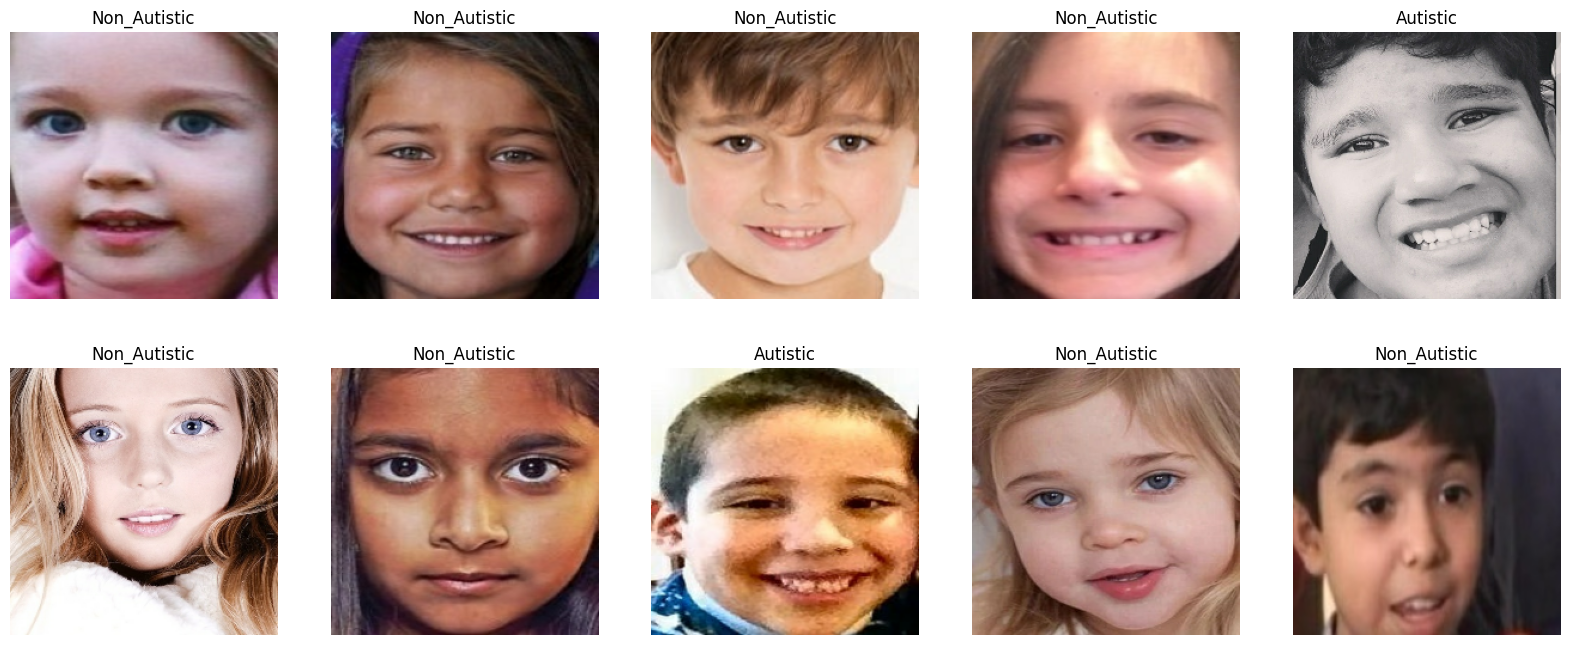

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1

for image, label in zip(images, labels):
    ax = fig.add_subplot(rows, cols, x)
    ax.imshow(image/255.)  # Assuming the image data is normalized to [0, 1]
    ax.axis("off")
    ax.set_title(label)
    x += 1

plt.show()


In [ ]:
input_shape = (224, 224, 3)

In [ ]:


def create_early_stopper():
    earlystopper = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1
    )
    return earlystopper


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
model_name = 'EfficientNetB4'
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define VGG16 base model
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=None  # Disable built-in pooling
)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Increase neurons to 512
x = BatchNormalization()(x)  # Add BatchNormalization
x = Dropout(rate=0.5)(x)
x = Dense(256, activation='relu')(x)  # Additional Dense layer with 256 neurons
x = BatchNormalization()(x)  # Add BatchNormalization
x = Dropout(rate=0.5)(x)
x = Dense(128, activation='relu')(x)  # Additional Dense layer with 128 neurons
x = Dropout(rate=0.5)(x)
output = Dense(class_count, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopper = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_data,
    epochs=60,
    validation_data=val_data,
    callbacks=[early_stopper, lr_scheduler]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print("Test Accuracy:", test_accuracy)



58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/60
74/74 [==============================] - 73s 536ms/step - loss: 1.3910 - accuracy: 0.5147 - val_loss: 1.8988 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/60
74/74 [==============================] - 33s 441ms/step - loss: 1.2207 - accuracy: 0.5134 - val_loss: 4.3487 - val_accuracy: 0.4966 - lr: 1.0000e-04
Epoch 3/60
74/74 [==============================] - 33s 445ms/step - loss: 1.2170 - accuracy: 0.4972 - val_loss: 1.3716 - val_accuracy: 0.4966 - lr: 1.0000e-04
Epoch 4/60
74/74 [==============================] - 34s 451ms/step - loss: 1.1086 - accuracy: 0.5557 - val_loss: 0.8608 - val_accuracy: 0.6336 - lr: 1.0000e-04
Epoch 5/60
74/74 [==============================] - 33s 438ms/step - loss: 0.9719 - accuracy: 0.5984 - val_loss: 0.9991 - val_accuracy: 0.6541 - lr: 1.0000e-04
Epoch 6/60
74/74 [==============================] - 33s 440ms/step - loss: 0.8872 - accuracy: 0.6214 - val_loss: 1.6386 - val_accuracy:

NameError: name 'test_labels' is not defined

10/10 [==============================] - 1s 129ms/step
              precision    recall  f1-score   support

    Autistic       0.72      0.77      0.74       147
Non_Autistic       0.75      0.69      0.72       147

    accuracy                           0.73       294
   macro avg       0.73      0.73      0.73       294
weighted avg       0.73      0.73      0.73       294



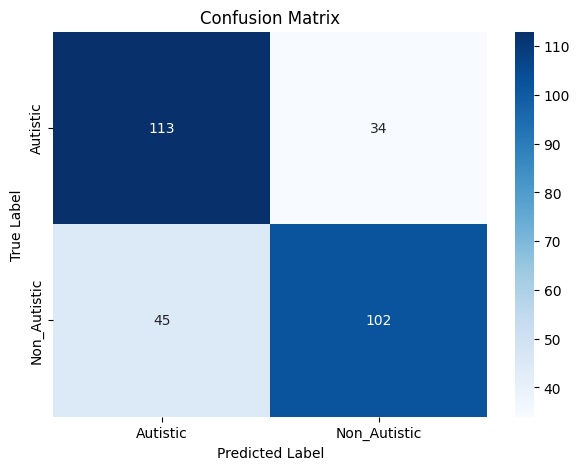

In [ ]:
y_pred_probs = model.predict(test_data)
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=train_data.class_names)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=train_data.class_names, yticklabels=train_data.class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

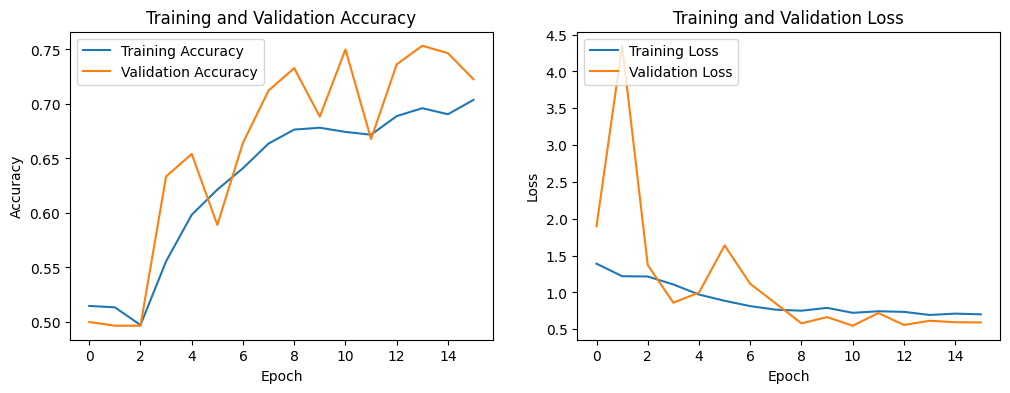

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training Loss', 'Validation Loss'], loc='upper left')

    plt.show()

plot_training_history(history)